# Membership Probability Notebook

This is where we'll identify overdensities in the observed data, and establish membership probabilities for each star in the observed dataset.

Here's how it works:

1. Import observed stars, simulated field stars, and Gala cluster stars
2. Create bins in the 5-D position-motion space (RA,DEC,PMRA,PMDEC,Px)
3. Count stars per unique arrangement of bins in 5-D space for each dataset
4. Create cluster and field likelihood maps that describe the overall distribution of the simulated field stars, and Gala's simulated cluster stars
5. Subtract simulated voxel counts from observed counts, calculate the ratio of residual stars to observed stars
6. Create a weighted probability using the cluster and field likelihood maps
7. Examine probability distributions, and export

In [1]:
# General imports
import pandas as pd
import numpy as np
from collections import defaultdict

# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.patches import Circle

# Math stuff
import math
from scipy.stats import norm
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter 

# 1. Import Stars

In [2]:
observed_df_cut = pd.read_csv('C:/Users/smick/Desktop/Research/notebooks/piecewise/observed_stars_mag_limited.csv')
simulated_df = pd.read_csv('C:/Users/smick/Desktop/Research/notebooks/piecewise/simulated_stars.csv')
gala_df = pd.read_csv('C:/Users/smick/Desktop/Research/notebooks/piecewise/gala_stars.csv')

# 2. Create Bins

In [3]:
# Establish the tidal radius
tidal_radius_as = 589.7 # (Pallanca, et al., 2023)
tidal_radius_deg = 589.7 / 3600 

# We want the tidal radius to be 10 bins across
radec_resolution = tidal_radius_deg / 10
print(f"Resolution for RA and DEC bins: {radec_resolution} degrees per bin" ) 

Resolution for RA and DEC bins: 0.016380555555555558 degrees per bin


In [4]:
# First, calculate average uncertainties to set bin widths to
pmra_uncertainty = np.mean(observed_df_cut['pmra_error'])
pmdec_uncertainty = np.mean(observed_df_cut['pmdec_error'])
px_uncertainty = np.mean(observed_df_cut['parallax_error'])

print(f"pmra uncertainty: {pmra_uncertainty}")
print(f"pmdec uncertainty: {pmdec_uncertainty}")
print(f"parallax uncertainty: {px_uncertainty}")

pmra uncertainty: 0.3530045115548001
pmdec uncertainty: 0.25904228006715774
parallax uncertainty: 0.3191508859207814


In [5]:
# Define the limits in each dimension. 
dec_min, dec_max = np.min(observed_df_cut['decdeg']), np.max(observed_df_cut['decdeg']) 
dec_center = (dec_min + dec_max) / 2 

ra_min, ra_max = np.min(observed_df_cut['radeg']), np.max(observed_df_cut['radeg']) 
ra_center = (ra_min + ra_max) / 2

pmra_min, pmra_max = -12.5, 7.5
pmdec_min, pmdec_max = -15.0, 5.0

plx_min, plx_max = -5, 5

# Set the desired resolution for each axis
ra_resolution = radec_resolution
dec_resolution = radec_resolution
pmra_resolution = 2 * pmra_uncertainty # 2x error to ensure stars don't blur into neighboring bins, measured in mas/year
pmdec_resolution = 2 * pmdec_uncertainty # mas/year
plx_resolution = 2 * px_uncertainty # mas 

# Now calculate number of bins needed to meet desired resolution
n_ra_bins = int((ra_max - ra_min) / ra_resolution) + 1
n_dec_bins = int((dec_max - dec_min) / dec_resolution) + 1
n_pmra_bins = int((pmra_max - pmra_min) / pmra_resolution) + 1
n_pmdec_bins = int((pmdec_max - pmdec_min) / pmdec_resolution) + 1
n_plx_bins = int((plx_max - plx_min) / plx_resolution) + 1

# Or just set number manually
#n_ra_bins = 20
#n_dec_bins = 20
#n_pmra_bins = 20
#n_pmdec_bins = 20
#n_plx_bins = 5

# Create the array of bins for each axis
ra_bins = np.linspace(ra_min, ra_max, n_ra_bins)
dec_bins = np.linspace(dec_min, dec_max, n_dec_bins)
pmra_bins = np.linspace(pmra_min, pmra_max, n_pmra_bins)
pmdec_bins = np.linspace(pmdec_min, pmdec_max, n_pmdec_bins)
plx_bins = np.linspace(plx_min, plx_max, n_plx_bins)

# Check how many bins we're working with. On a modern machine, an arrangement around the size of 
# (100,100,30,30,15) will take around 30-45 minutes to process
print(f"Bin arrangement (RA,DEC,PMRA,PMDEC,PX): {len(ra_bins),len(dec_bins),len(pmra_bins), len(pmdec_bins), len(plx_bins)}")

Bin arrangement (RA,DEC,PMRA,PMDEC,PX): (72, 62, 29, 39, 16)


# 3. Count stars

To count stars, we'll first use the digitize function to assign indices that reflect the parent bin to each star in place of it's actual value. We'll need to define a function that adjusts how digitize works to make sure the bins are as we'd expect.

In [6]:
# Function that takes in the data and bins specified above, digitizes and outputs a list of indices for each star to each variable
def digitize_and_adjust(values, bins, out_of_range_low_bin, out_of_range_high_bin):

    # Assign indices
    indices = np.digitize(values, bins, right=True)
    
    # Adjust indices for out-of-range values
    adjusted_indices = []
    for value, index in zip(values, indices):
        if value < bins[0]:
            adjusted_indices.append(out_of_range_low_bin)
        elif value > bins[-1]:
            adjusted_indices.append(out_of_range_high_bin)
        elif value == bins[0]:
            adjusted_indices.append(1)  # because digitize places only values equal to lower edge of the range in bin 0, we need to tell it bin 1 instead so the star gets counted properly
        else:
            adjusted_indices.append(index)
    
    return np.array(adjusted_indices, dtype=int)

# Define bins for out-of-range values
ra_out_of_range_low_bin = len(ra_bins) 
ra_out_of_range_high_bin = len(ra_bins) +1

dec_out_of_range_low_bin = len(dec_bins) 
dec_out_of_range_high_bin = len(dec_bins) +1

pmra_out_of_range_low_bin = len(pmra_bins) 
pmra_out_of_range_high_bin = len(pmra_bins) +1

pmdec_out_of_range_low_bin = len(pmdec_bins) 
pmdec_out_of_range_high_bin = len(pmdec_bins) +1

plx_out_of_range_low_bin = len(plx_bins) 
plx_out_of_range_high_bin = len(plx_bins) +1

Now use it to assign the indices for each dataset

In [7]:
observed_ra_indices = digitize_and_adjust(observed_df_cut['radeg'], ra_bins, ra_out_of_range_low_bin, ra_out_of_range_high_bin)
observed_dec_indices = digitize_and_adjust(observed_df_cut['decdeg'], dec_bins, dec_out_of_range_low_bin, dec_out_of_range_high_bin)
observed_pmra_indices = digitize_and_adjust(observed_df_cut['pmra'], pmra_bins, pmra_out_of_range_low_bin, pmra_out_of_range_high_bin)
observed_pmdec_indices = digitize_and_adjust(observed_df_cut['pmdec'], pmdec_bins, pmdec_out_of_range_low_bin, pmdec_out_of_range_high_bin)
observed_plx_indices = digitize_and_adjust(observed_df_cut['parallax'], plx_bins, plx_out_of_range_low_bin, plx_out_of_range_high_bin)

simulated_ra_indices = digitize_and_adjust(simulated_df['radeg'], ra_bins, ra_out_of_range_low_bin, ra_out_of_range_high_bin)
simulated_dec_indices = digitize_and_adjust(simulated_df['decdeg'], dec_bins, dec_out_of_range_low_bin, dec_out_of_range_high_bin)
simulated_pmra_indices = digitize_and_adjust(simulated_df['pmra'], pmra_bins, pmra_out_of_range_low_bin, pmra_out_of_range_high_bin)
simulated_pmdec_indices = digitize_and_adjust(simulated_df['pmdec'], pmdec_bins, pmdec_out_of_range_low_bin, pmdec_out_of_range_high_bin)
simulated_plx_indices = digitize_and_adjust(simulated_df['parallax'], plx_bins, plx_out_of_range_low_bin, plx_out_of_range_high_bin,)

gala_ra_indices = digitize_and_adjust(gala_df['RA'], ra_bins, ra_out_of_range_low_bin, ra_out_of_range_high_bin)
gala_dec_indices = digitize_and_adjust(gala_df['DEC'], dec_bins, dec_out_of_range_low_bin, dec_out_of_range_high_bin)
gala_pmra_indices = digitize_and_adjust(gala_df['PM_RA'], pmra_bins, pmra_out_of_range_low_bin, pmra_out_of_range_high_bin)
gala_pmdec_indices = digitize_and_adjust(gala_df['PM_DEC'], pmdec_bins, pmdec_out_of_range_low_bin, pmdec_out_of_range_high_bin)
gala_plx_indices = digitize_and_adjust(gala_df['PX'], plx_bins, plx_out_of_range_low_bin, plx_out_of_range_high_bin)

Now that we have the values digitized, we can look at each unique arrangement of bins, or what we will call a "voxel", and count how many stars we have. Each voxel is just a cube extended into N-dimensional space, 5D in this case, and we are counting how many fall within each.

In [8]:
# Initialize array for voxel counts
observed_voxel_counts = np.zeros( (len(ra_bins)+2, len(dec_bins)+2, len(pmra_bins)+2, len(pmdec_bins)+2, len(plx_bins)+2), dtype=np.int32 )
simulated_voxel_counts = np.zeros( (len(ra_bins)+2, len(dec_bins)+2, len(pmra_bins)+2, len(pmdec_bins)+2, len(plx_bins)+2), dtype=np.int32 )
gala_voxel_counts = np.zeros( (len(ra_bins)+2, len(dec_bins)+2, len(pmra_bins)+2, len(pmdec_bins)+2, len(plx_bins)+2), dtype=np.int32 )

# Increment the count for each variable
np.add.at(observed_voxel_counts, (observed_ra_indices, observed_dec_indices,
                                 observed_pmra_indices, observed_pmdec_indices,
                                 observed_plx_indices), 1)
np.add.at(simulated_voxel_counts, (simulated_ra_indices, simulated_dec_indices,
                                 simulated_pmra_indices, simulated_pmdec_indices,
                                 simulated_plx_indices), 1)
np.add.at(gala_voxel_counts, (gala_ra_indices, gala_dec_indices,
                                 gala_pmra_indices, gala_pmdec_indices,
                                 gala_plx_indices), 1)

# 4. Create likelihood maps

Here we'll use our two sets of simulated data to create two maps that tell us where we should expect cluster and field stars to be.

The Gala stars are simulated with a relatively large distribution in RA,DEC space, but are highly concentrated in PMRA,PMDEC space. To simulate a higher spread of uncertainty in the data to avoid any kind of overconfidence in the simulation, we'll apply some gaussian smoothing to the Gala stars data to spread them out.

In [9]:
# Set bandwith for smoothing in sigmas for [RA,DEC,PMRA,PMDEC,PX] spaces
sigma = [1, 1, 1, 1, 0.1]  

# Apply smoothing 
gala_smoothed_counts = gaussian_filter(gala_voxel_counts, sigma=sigma)

# Calculate the likelihood map as the ratio of number of stars within each voxel to the total number of Gala stars in the truncated dataset. This will have a max value less than one everywhere. 
#clm = gala_voxel_counts / np.sum(gala_voxel_counts)

# Or as the number of stars within each voxel to the max number found in any voxel. This will generate one voxel with a density of 1. 
clm = gala_smoothed_counts / np.max(gala_smoothed_counts)

# The BDBS field is much more evenly distributed and doesn't exactly need the smoothing
flm = simulated_voxel_counts/ np.max(simulated_voxel_counts)

Take a look at how these likehood maps are distributed

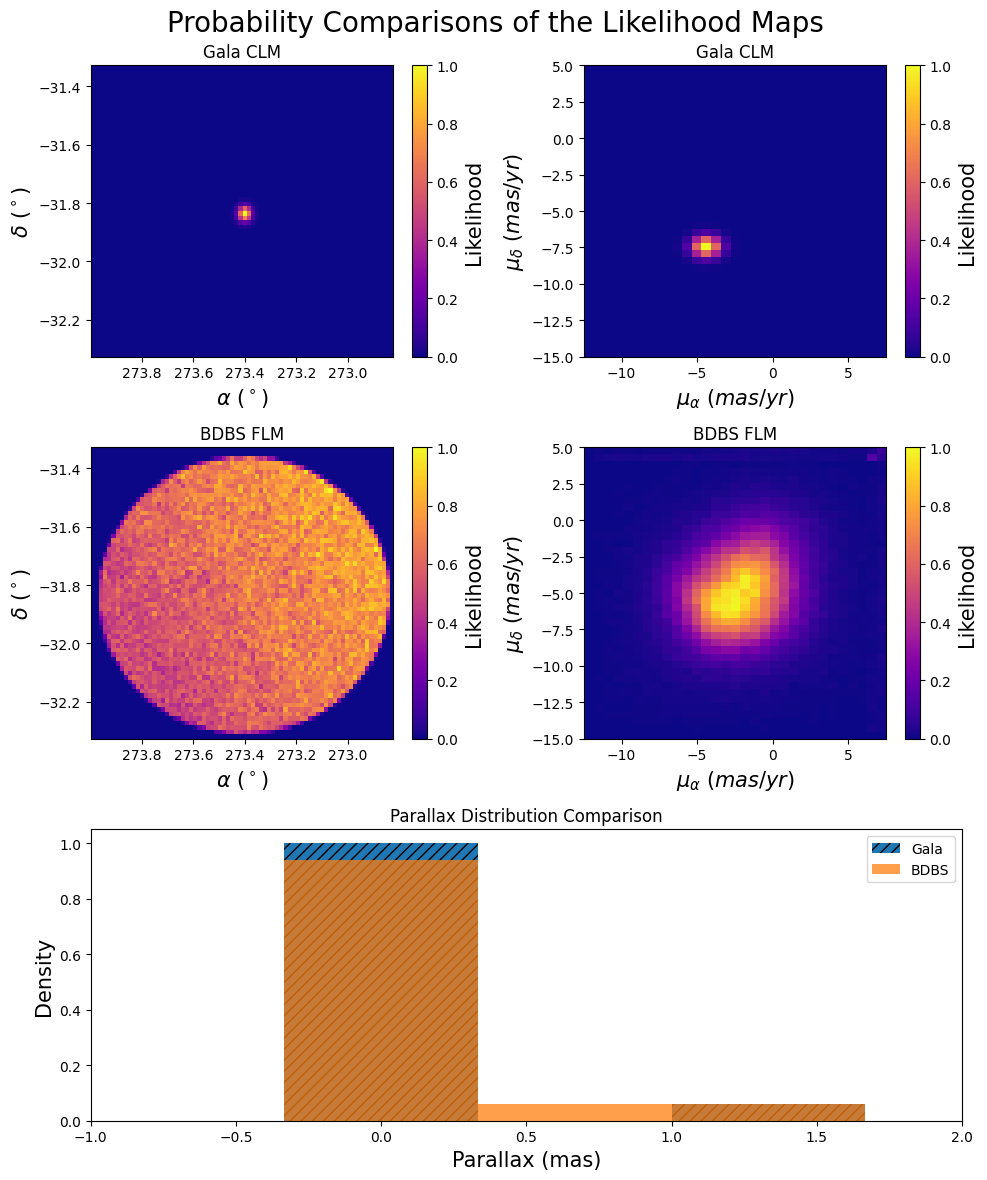

In [10]:
# Collapse down to the desired dimensions for plotting [0-4 in order: RA,DEC,PMRA,PMDEC,Px]
clm_ra_dec =clm.sum(axis=(4,3,2))
clm_pm_ra_dec = clm.sum(axis=(4,1,0))
clm_px = clm.sum(axis=(3,2,1,0))

flm_ra_dec =flm.sum(axis=(4,3,2))
flm_pm_ra_dec = flm.sum(axis=(4,1,0))
flm_px = flm.sum(axis=(3,2,1,0))

# Re-normalize the summed maps
clm_ra_dec /= clm_ra_dec.max()
clm_pm_ra_dec /= clm_pm_ra_dec.max()
clm_px /= clm_px.max()

flm_ra_dec /= flm_ra_dec.max()
flm_pm_ra_dec /= flm_pm_ra_dec.max()
flm_px /= flm_px.max()

# Compute histograms for GALA and simulated parallaxes
gala_px_hist, _ = np.histogram(clm_px, bins=plx_bins, density=True)
simulated_px_hist, _ = np.histogram(flm_px, bins=plx_bins, density=True)
px_centers = 0.5 * (plx_bins[:-1] + plx_bins[1:])
max_val = max(gala_px_hist.max(), simulated_px_hist.max())
gala_px_hist /= max_val
simulated_px_hist /= max_val

# Set up the plots
fig = plt.figure(figsize=(10, 12))
fig.suptitle('Probability Comparisons of the Likelihood Maps', fontsize=20)
gs = gridspec.GridSpec(3, 2, figure=fig, height_ratios=[1,1,1]) # allows for custom configurations of plots

# Top row plots for positions and motions
ax_gala_radec   = fig.add_subplot(gs[0, 0])
ax_gala_pm      = fig.add_subplot(gs[0, 1])
ax_simulated_radec   = fig.add_subplot(gs[1, 0])
ax_simulated_pm      = fig.add_subplot(gs[1, 1])

# Bottom row for a single wide subplot of the parallax histogram
ax_parallax = fig.add_subplot(gs[2, :])  # spans all columns in the row

# Plot the positions and motions in the top row
im1 = ax_gala_radec.imshow(clm_ra_dec.T, origin='lower', 
                           interpolation='none', aspect='auto', 
                           extent=[ra_min, ra_max, dec_min, dec_max], cmap='plasma')
ax_gala_radec.invert_xaxis()
ax_gala_radec.set_xlabel(r'$\alpha$ $(^\circ)$', fontsize=15)
ax_gala_radec.set_ylabel(r'$\delta$ $(^\circ)$', fontsize=15)
ax_gala_radec.set_title('Gala CLM')
fig.colorbar(im1, ax=ax_gala_radec).set_label('Likelihood', fontsize=15)

im2 = ax_gala_pm.imshow(clm_pm_ra_dec.T, interpolation='none', 
                        origin='lower', aspect='auto', 
                        extent=[pmra_min, pmra_max, pmdec_min, pmdec_max], cmap='plasma')
ax_gala_pm.set_xlabel(r'$\mu_\alpha$ $(mas/yr)$', fontsize=15)
ax_gala_pm.set_ylabel(r'$\mu_\delta$ $(mas/yr)$', fontsize=15)
ax_gala_pm.set_title('Gala CLM')
fig.colorbar(im2, ax=ax_gala_pm).set_label('Likelihood', fontsize=15)

im3 = ax_simulated_radec.imshow(flm_ra_dec.T, origin='lower', 
                           interpolation='none', aspect='auto', 
                           extent=[ra_min, ra_max, dec_min, dec_max], cmap='plasma')
ax_simulated_radec.invert_xaxis()
ax_simulated_radec.set_xlabel(r'$\alpha$ $(^\circ)$', fontsize=15)
ax_simulated_radec.set_ylabel(r'$\delta$ $(^\circ)$', fontsize=15)
ax_simulated_radec.set_title('BDBS FLM')
fig.colorbar(im3, ax=ax_simulated_radec).set_label('Likelihood', fontsize=15)

im4 = ax_simulated_pm.imshow(flm_pm_ra_dec.T, interpolation='none', 
                        origin='lower', aspect='auto', 
                        extent=[pmra_min, pmra_max, pmdec_min, pmdec_max], cmap='plasma')
ax_simulated_pm.set_xlabel(r'$\mu_\alpha$ $(mas/yr)$', fontsize=15)
ax_simulated_pm.set_ylabel(r'$\mu_\delta$ $(mas/yr)$', fontsize=15)
ax_simulated_pm.set_title('BDBS FLM')
fig.colorbar(im4, ax=ax_simulated_pm).set_label('Likelihood', fontsize=15)

# Add in the combined parallax histogram for the last row
bin_width = plx_bins[1] - plx_bins[0]
ax_parallax.bar(px_centers, gala_px_hist, width=bin_width, label='Gala', alpha=1, hatch='///')
ax_parallax.bar(px_centers, simulated_px_hist, width=bin_width, label='BDBS', alpha=0.75)
ax_parallax.set_xlabel('Parallax (mas)', fontsize=15)
ax_parallax.set_xlim(-1,2)
ax_parallax.set_ylabel('Density', fontsize=15)
ax_parallax.set_title('Parallax Distribution Comparison')
ax_parallax.legend()

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

# 5. Subtract and calculate residual ratio

This is where we'll collect all of our voxels from the observed and simulated datasets, and calculate a residual ratio that tells us, on a per-voxel basis, how many observed stars there are compared to simulated stars. 

First, precompute everything we'll need to sort and calculate membership probabilities.

**NOTE: This code currently matches on the N6569 oID. This has to be updated for any new data source.** 

In [11]:
# Calculate residual array
residuals = observed_voxel_counts - simulated_voxel_counts

# Prepare the residual array for sorting and membership calculations
residuals = residuals.astype(float)
residuals[np.isnan(residuals)] = -np.inf 

# Flatten and sort
flattened_residuals = residuals.flatten()
sorted_indices = np.argsort(flattened_residuals)[::-1]
all_voxels = np.unravel_index(sorted_indices, residuals.shape)

# Stack the voxel indices of the original counts
observed_voxel_indices = np.stack([observed_ra_indices, observed_dec_indices, observed_pmra_indices, observed_pmdec_indices, observed_plx_indices], axis=1)
simulated_voxel_indices = np.stack([simulated_ra_indices, simulated_dec_indices, simulated_pmra_indices, simulated_pmdec_indices, simulated_plx_indices], axis=1)
gala_voxel_indices = np.stack([gala_ra_indices, gala_dec_indices, gala_pmra_indices, gala_pmdec_indices, gala_plx_indices], axis=1)

# Get all n6569_oid values and their indices from the full and field datasets
observed_n6569_oids = observed_df_cut['n6569_oid'].values  
simulated_n6569_oids = simulated_df['n6569_oid'].values  

# Compute residual n6569_oids
residual_n6569_oids = np.setdiff1d(observed_n6569_oids, simulated_n6569_oids)

# Mask to where we have matching ID's between the full set and residuals
residual_mask = np.isin(observed_n6569_oids, residual_n6569_oids)
residual_full_indices = np.where(residual_mask)[0]

# Get the voxel indices for the residual stars
residual_voxel_indices = observed_voxel_indices[residual_full_indices]

# Convert voxel indices to tuples for easier grouping
residual_voxel_tuples = [tuple(idx) for idx in residual_voxel_indices]

# Create a DataFrame for residual stars
residual_stars_df = pd.DataFrame({
    'voxel_idx': residual_voxel_tuples,
    'n6569_oid': residual_n6569_oids,
    'full_index': residual_full_indices
})

# Group residual stars by voxel indices
grouped_residual_stars = residual_stars_df.groupby('voxel_idx')

Now we'll create a new dataframe that contains the voxel information by looping through each voxel in the residual array, finding any stars from the real and simulated datasets that fall within, and creating entries for the voxel data. 

In [12]:
def bin_edges(bins, index):
    if index <= 0 or index >= len(bins):
        return (np.nan, np.nan)
    else:
        return (bins[index - 1], bins[index])

observed_dict = defaultdict(list)
for i, idx in enumerate(observed_voxel_indices):
    observed_dict[tuple(idx)].append(i)

simulated_dict = defaultdict(list)
for i, idx in enumerate(simulated_voxel_indices):
    simulated_dict[tuple(idx)].append(i)

voxel_info_list = []

for voxel_idx, residual_value in zip(zip(*all_voxels), flattened_residuals[sorted_indices]):
    if residual_value == -np.inf:
        continue
    
    # bin edges
    ra_range = bin_edges(ra_bins, voxel_idx[0])
    dec_range = bin_edges(dec_bins, voxel_idx[1])
    pmra_range = bin_edges(pmra_bins, voxel_idx[2])
    pmdec_range = bin_edges(pmdec_bins, voxel_idx[3])
    plx_range = bin_edges(plx_bins, voxel_idx[4])

    voxel_tuple = tuple(voxel_idx)

    if voxel_tuple in grouped_residual_stars.groups:
        residual_stars = grouped_residual_stars.get_group(voxel_tuple)
        residual_star_count = len(residual_stars)
    else:
        residual_star_count = 0

    if residual_star_count == 0:
        continue

    # O(1) dict lookup instead of np.all(..., axis=1)
    observed_matching_indices = observed_dict.get(voxel_tuple, [])
    simulated_matching_indices = simulated_dict.get(voxel_tuple, [])

    # Append
    voxel_info_list.append({
        'RA Range': ra_range,
        'DEC Range': dec_range,
        'PMRA Range': pmra_range,
        'PMDEC Range': pmdec_range,
        'Parallax Range': plx_range,
        'Residual Count': residual_value,
        'CLM Density': clm[voxel_idx],
        'FLM Density': flm[voxel_idx],
        'Observed Star Count': len(observed_matching_indices),
        'Simulated Star Count': len(simulated_matching_indices),
        'Residual Star Indices': residual_stars['full_index'].values,
        'Residual Star IDs': residual_stars['n6569_oid'].tolist()
    })

voxel_df = pd.DataFrame(voxel_info_list)

Now calculate the residual ratio for each voxel

In [13]:
voxel_df['Residual Ratio'] = voxel_df['Residual Count'] / voxel_df['Observed Star Count']
voxel_df['Residual Ratio'] = voxel_df['Residual Ratio'].fillna(0)

# 6. Calculate the weighted probability

Our residual ratio tells us that where have an overdensity of observed stars. We need to now take that value, and compare it to where the simulations tell us we should expect to see cluster or field stars.

In [14]:
# Create a copy of the residual ratio values
voxel_df['Gala Weighted Residual'] = voxel_df['Residual Ratio']

# We'll now weight the residual ratio by applying a Bayesian that incorporates our field and cluster likelihood maps
# First calculate numerator and denominator, and then calculate while replacing any NaN's with 0s 
res_num = voxel_df['Residual Ratio'] * voxel_df['CLM Density']
res_den = res_num + voxel_df['FLM Density'] * (1 - voxel_df['CLM Density'])
res_bayesian_probability = np.where(res_den != 0, res_num / res_den, 0) # We'll take this, and apply it only to high probability stars


# Apply the calculation to voxels above only a certain threshold of residual ratio, and retain the original residual ratio where it doesn't meet
voxel_df['Gala Weighted Residual'] = np.where(
    voxel_df['Residual Ratio'] >= 0.50, # set threshold to anywhere we have twice as many observed stars as simulated stars
    res_bayesian_probability,
    voxel_df['Gala Weighted Residual']
)

# Modified Gala Weighted Residual to simply keep residual ratio when Gala indicates cluster stars are also present 
voxel_df['Gatekeeper Residual'] = np.where(
    voxel_df['CLM Density'] > 0.25,
    voxel_df['Residual Ratio'],
    0
)

We can now assign this probability, along with the residual ratio and anything else we need, to the original observed stars. 

In [15]:
# First, pull ID's and values from observed stars
observed_stars_info = observed_df_cut.set_index('n6569_oid')[['radeg', 'decdeg', 'pmra', 'pmdec', 'parallax', 'rmag_extcorr', 'gmag_extcorr','zmag_extcorr', 'imag_extcorr']]

# Create an empty list to store the results for the new dataframe
observed_probs = []

# Loop through each voxel in the residual DataFrame
for _, voxel_row in voxel_df.iterrows():
    voxel_idx = voxel_row[['RA Range', 'DEC Range', 'PMRA Range', 'PMDEC Range', 'Parallax Range']].values

    # Specify the variables from the residual DataFrame that we want to include
    residual_ratio = voxel_row['Residual Ratio']
    flm_density = voxel_row['FLM Density']
    gala_weighted_residual = voxel_row['Gala Weighted Residual']
    gatekeeper_residual = voxel_row['Gatekeeper Residual']
    clm_density = voxel_row['CLM Density']
    residual_matching_indices = voxel_row['Residual Star Indices']

    # Skip if there are no residual stars
    if residual_matching_indices.size == 0:
        continue

    # Append info from observed stars and the residual DataFrame
    matching_observed_stars = observed_stars_info.iloc[residual_matching_indices]
    for oid, star_data in matching_observed_stars.iterrows():
        observed_probs.append({
            'n6569_oid': oid,
            'radeg': star_data['radeg'],
            'decdeg': star_data['decdeg'],
            'pmra': star_data['pmra'],
            'pmdec': star_data['pmdec'],
            'Parallax': star_data['parallax'],
            'gmag_extcorr': star_data['gmag_extcorr'],
            'rmag_extcorr': star_data['rmag_extcorr'],
            'imag_extcorr': star_data['imag_extcorr'],
            'zmag_extcorr': star_data['zmag_extcorr'],
            'Residual_Ratio': residual_ratio,
            'CLM Density': clm_density,
            'FLM Density': flm_density,
            'Gala Weighted Residual': gala_weighted_residual,
            'Gatekeeper Residual': gatekeeper_residual,
            'Voxel Index': voxel_idx
        })

# Convert the results to a DataFrame
observed_probs_df = pd.DataFrame(observed_probs)

# Output the top 10 stars by Gala Weighted Residual to make sure things are looking as we'd expect
print(observed_probs_df.head(10))

   n6569_oid      radeg    decdeg      pmra     pmdec  Parallax  gmag_extcorr  \
0     341269  273.40436 -31.83479 -4.071813 -7.223560  0.099505        16.736   
1     341554  273.40480 -31.82383 -4.048766 -7.485703  0.091450        15.312   
2     341592  273.40490 -31.83049 -4.372165 -7.553352 -0.160396        16.932   
3     341686  273.40508 -31.82296 -4.142184 -7.149219  0.242066        14.843   
4     342313  273.40618 -31.82405 -4.076820 -7.179788  0.092364        15.224   
5     342353  273.40626 -31.82473 -4.218332 -7.324676  0.040622        15.178   
6     342407  273.40634 -31.82146 -3.951567 -7.440965  0.103241        16.423   
7     340679  273.40327 -31.81929 -4.084663 -7.302984  0.017323        15.970   
8     340774  273.40344 -31.83511 -4.005710 -7.537175 -0.283848        19.100   
9     340793  273.40347 -31.82720 -3.963927 -7.435491  0.333046        16.690   

   rmag_extcorr  imag_extcorr  zmag_extcorr  Residual_Ratio  CLM Density  \
0        16.137        15.882   

# 7. Plot and export

First, filter stars by probability 

In [16]:
low_probs = observed_probs_df[observed_probs_df['Gala Weighted Residual'] < 0.5]
med_and_high_probs = observed_probs_df[observed_probs_df['Gala Weighted Residual'] >= 0.5]
high_probs = observed_probs_df[observed_probs_df['Gala Weighted Residual'] >= 0.85]

In [17]:
# Repeat for gatekeeper residuals
gk_low_probs = observed_probs_df[observed_probs_df['Gatekeeper Residual'] < 0.5]
gk_med_and_high_probs = observed_probs_df[observed_probs_df['Gatekeeper Residual'] >= 0.5]
gk_high_probs = observed_probs_df[observed_probs_df['Gatekeeper Residual'] >= 0.85]

Let's take a look at the distributions of the CLM, FLM, Residual Ratio, and the Gala Weighted Residual

C:\Users\smick\AppData\Local\Temp\ipykernel_63224\3602584130.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


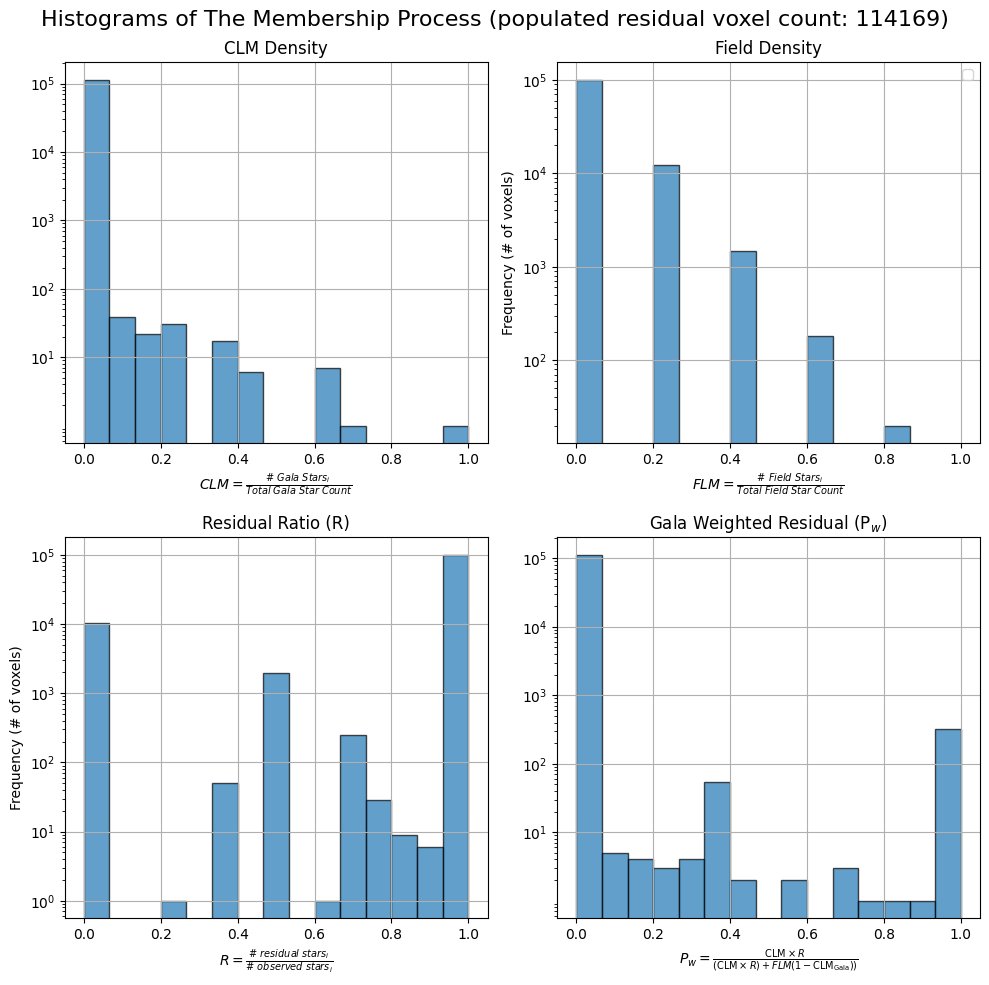

In [18]:
# Plotting the chain of probability calculations, starting from residual ratio and ending with the Gala weighted probability
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Histograms of The Membership Process (populated residual voxel count: {len(voxel_df['Residual Ratio'])})", fontsize=16)
axs = axs.ravel()

# CLM 
axs[0].hist(voxel_df['CLM Density'], bins=15, edgecolor='black', alpha=0.7, range=(0, 1))
axs[0].set_yscale('log')
axs[0].set_yticks([10**i for i in range(1, int(np.log10(axs[3].get_ylim()[1])) + 1)])
axs[0].set_title("CLM Density")
axs[0].set_xlabel(r"$CLM =  \frac{\# \ Gala \ Stars_i}{Total \ Gala \ Star \ Count}$")
axs[0].grid()

# FLM 
axs[1].hist(voxel_df['FLM Density'], range=[0, 1], bins=15, edgecolor='black', alpha=0.7)
axs[1].set_yscale('log')
axs[0].set_yticks([10**i for i in range(1, int(np.log10(axs[0].get_ylim()[1])) + 1)])
axs[1].set_title("Field Density")
axs[1].set_xlabel(r"$FLM = \frac{\# \ Field \  Stars_i}{Total  \ Field \ Star  \ Count}$")
axs[1].set_ylabel('Frequency (# of voxels)')
axs[1].legend()
axs[1].grid()

# Residual Ratio 
axs[2].hist(voxel_df['Residual Ratio'], bins=15, edgecolor='black', alpha=0.7, range=(0, 1))
axs[2].set_yscale('log')
axs[0].set_yticks([10**i for i in range(1, int(np.log10(axs[1].get_ylim()[1])) + 1)])
axs[2].set_title("Residual Ratio (R)")
axs[2].set_ylabel('Frequency (# of voxels)')
axs[2].set_xlabel(r"$R=\frac{\# \ residual \ stars_i}{\# \ observed \ stars_i }$")
axs[2].grid()

# Gala Weighted Residual
axs[3].hist(voxel_df['Gala Weighted Residual'], bins=15, edgecolor='black', alpha=0.7, range=(0, 1))
axs[3].set_yscale('log')
axs[3].set_yticks([10**i for i in range(1, int(np.log10(axs[2].get_ylim()[1])) + 1)])
axs[3].set_title(r"Gala Weighted Residual (P$_w$)")
axs[3].set_xlabel(r"$P_w = \frac{\mathrm{CLM} \times R}"
          r"{(\mathrm{CLM} \times R) + FLM(1 - \mathrm{CLM_{Gala}}))}$")
axs[3].grid()

# Adjust spacing and plot
fig.tight_layout(rect=[0, 0, 1, 1])
plt.show()

Next, let's see how our the process of subtracting to obtain the residual ratio looks, and compare that to Gala predictions.

In [19]:
# Isolate two variables at a time for plotting
observed_voxel_counts_ra_dec =observed_voxel_counts.sum(axis=(4,3,2))
observed_voxel_counts_pmra_pmdec = observed_voxel_counts.sum(axis=(4,1,0))

simulated_voxel_counts_ra_dec = simulated_voxel_counts.sum(axis=(4,3,2))
simulated_voxel_counts_pmra_pmdec = simulated_voxel_counts.sum(axis=(4,1,0))

residual_counts_ra_dec = residuals.sum(axis=(4,3,2))
residual_counts_pmra_pmdec = residuals.sum(axis=(4,1,0))

gala_voxel_counts_ra_dec =gala_voxel_counts.sum(axis=(4,3,2))
gala_voxel_counts_pmra_pmdec = gala_voxel_counts.sum(axis=(4,1,0))

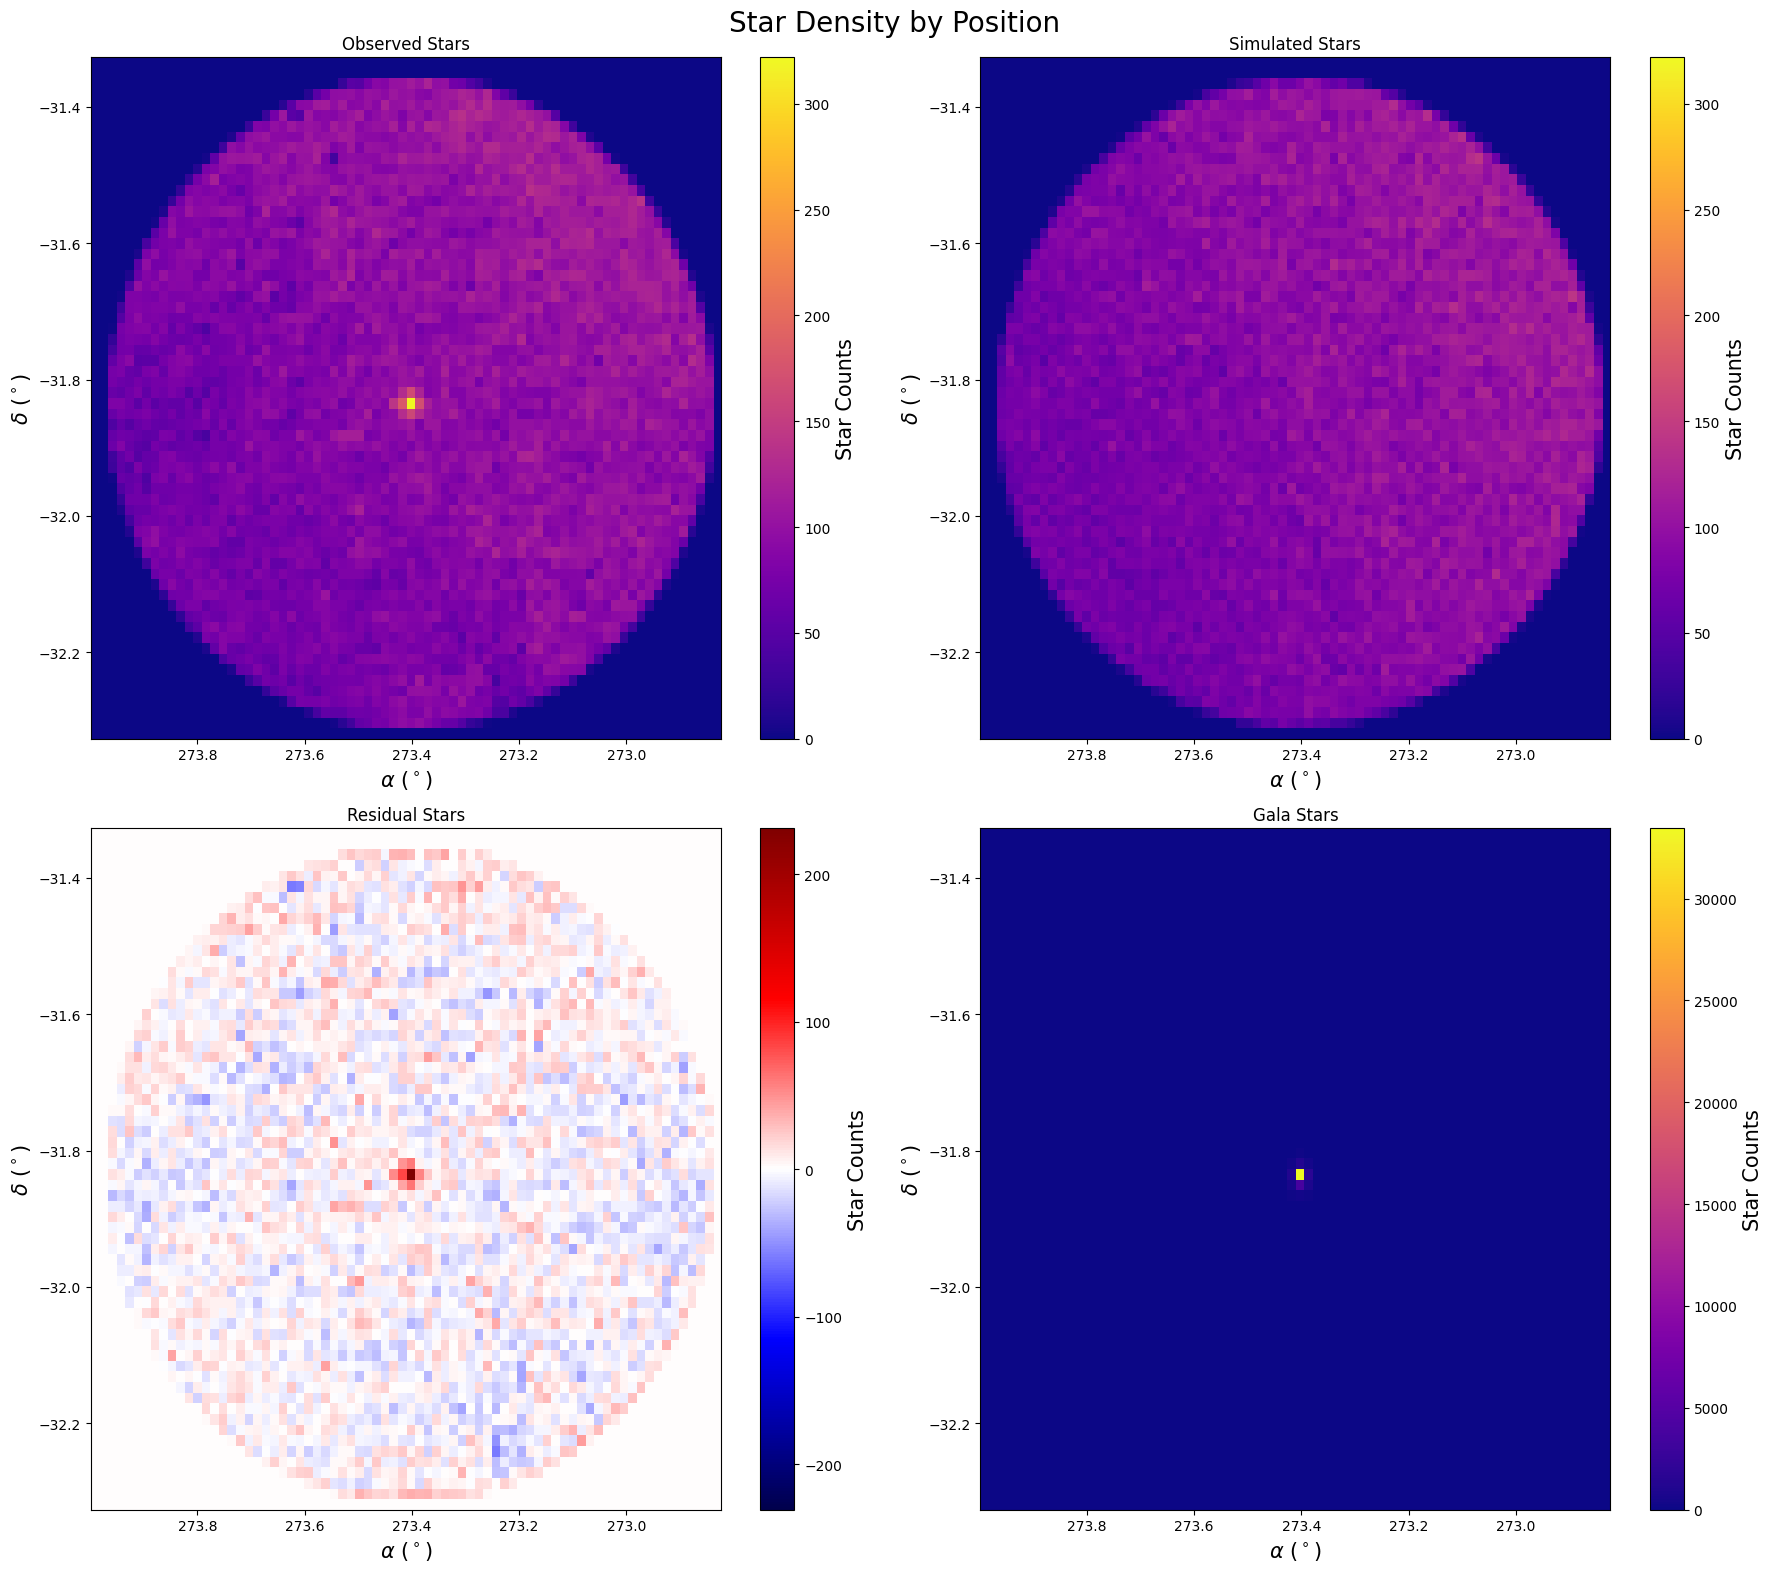

In [20]:
# Plot positions of full, field, residual and Gala stars
fig, axs = plt.subplots(2, 2, figsize=(18, 16))
fig.suptitle('Star Density by Position', fontsize=20)
axs = axs.ravel()

# Calculate a min and max for consistent colorbar
vmin = min(simulated_voxel_counts_ra_dec.min(), observed_voxel_counts_ra_dec.min())
vmax = max(simulated_voxel_counts_ra_dec.max(), observed_voxel_counts_ra_dec.max())

# Observed data
im1 = axs[0].imshow(observed_voxel_counts_ra_dec.T, origin='lower', 
                    interpolation='none', aspect='auto', extent=[ra_min, ra_max, dec_min, dec_max], vmin=vmin, vmax=vmax, cmap='plasma')
axs[0].invert_xaxis()
axs[0].set_xlim(ra_max, ra_min)
axs[0].set_ylim(dec_min, dec_max)
axs[0].set_xlabel(r'$\alpha$ $(^\circ)$', fontsize=15)
axs[0].set_ylabel(r'$\delta$ $(^\circ)$', fontsize=15)
axs[0].set_title('Observed Stars')
cbar1 = fig.colorbar(im1, ax=axs[0])
cbar1.set_label('Star Counts', fontsize=15)

# Simulated data
im2 = axs[1].imshow(simulated_voxel_counts_ra_dec.T, interpolation='none', 
                    origin='lower', aspect='auto', extent=[ra_min, ra_max, dec_min, dec_max], vmin=vmin, vmax=vmax, cmap='plasma')
axs[1].invert_xaxis()
axs[1].set_xlim(ra_max, ra_min)
axs[1].set_ylim(dec_min, dec_max)
axs[1].set_xlabel(r'$\alpha$ $(^\circ)$', fontsize=15)
axs[1].set_ylabel(r'$\delta$ $(^\circ)$', fontsize=15)
axs[1].set_title('Simulated Stars')
cbar2 = fig.colorbar(im2, ax=axs[1])
cbar2.set_label('Star Counts', fontsize=15)

# Residual
residual_vmin = residual_counts_ra_dec.min()
residual_vmax = residual_counts_ra_dec.max()

residual_abs_max = max(abs(residual_vmin), abs(residual_vmax))
residual_vmin = -residual_abs_max
residual_vmax = residual_abs_max

im3 = axs[2].imshow(residual_counts_ra_dec.T, origin='lower', 
                    interpolation='none', aspect='auto', extent=[ra_min, ra_max, dec_min, dec_max], vmin=residual_vmin, vmax=residual_vmax, cmap='seismic')
axs[2].invert_xaxis()
axs[2].set_xlim(ra_max, ra_min)
axs[2].set_ylim(dec_min, dec_max)
axs[2].set_xlabel(r'$\alpha$ $(^\circ)$', fontsize=15)
axs[2].set_ylabel(r'$\delta$ $(^\circ)$', fontsize=15)
axs[2].set_title('Residual Stars')
cbar3 = fig.colorbar(im3, ax=axs[2])
cbar3.set_label('Star Counts', fontsize=15)

# Gala
im4 = axs[3].imshow(gala_voxel_counts_ra_dec.T, origin='lower', 
                    interpolation='none', aspect='auto', extent=[ra_min, ra_max, dec_min, dec_max], cmap='plasma')
axs[3].invert_xaxis()
axs[3].set_xlim(ra_max, ra_min)
axs[3].set_ylim(dec_min, dec_max)
axs[3].set_xlabel(r'$\alpha$ $(^\circ)$', fontsize=15)
axs[3].set_ylabel(r'$\delta$ $(^\circ)$', fontsize=15)
axs[3].set_title('Gala Stars')
cbar4 = fig.colorbar(im4, ax=axs[3])
cbar4.set_label('Star Counts', fontsize=15)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

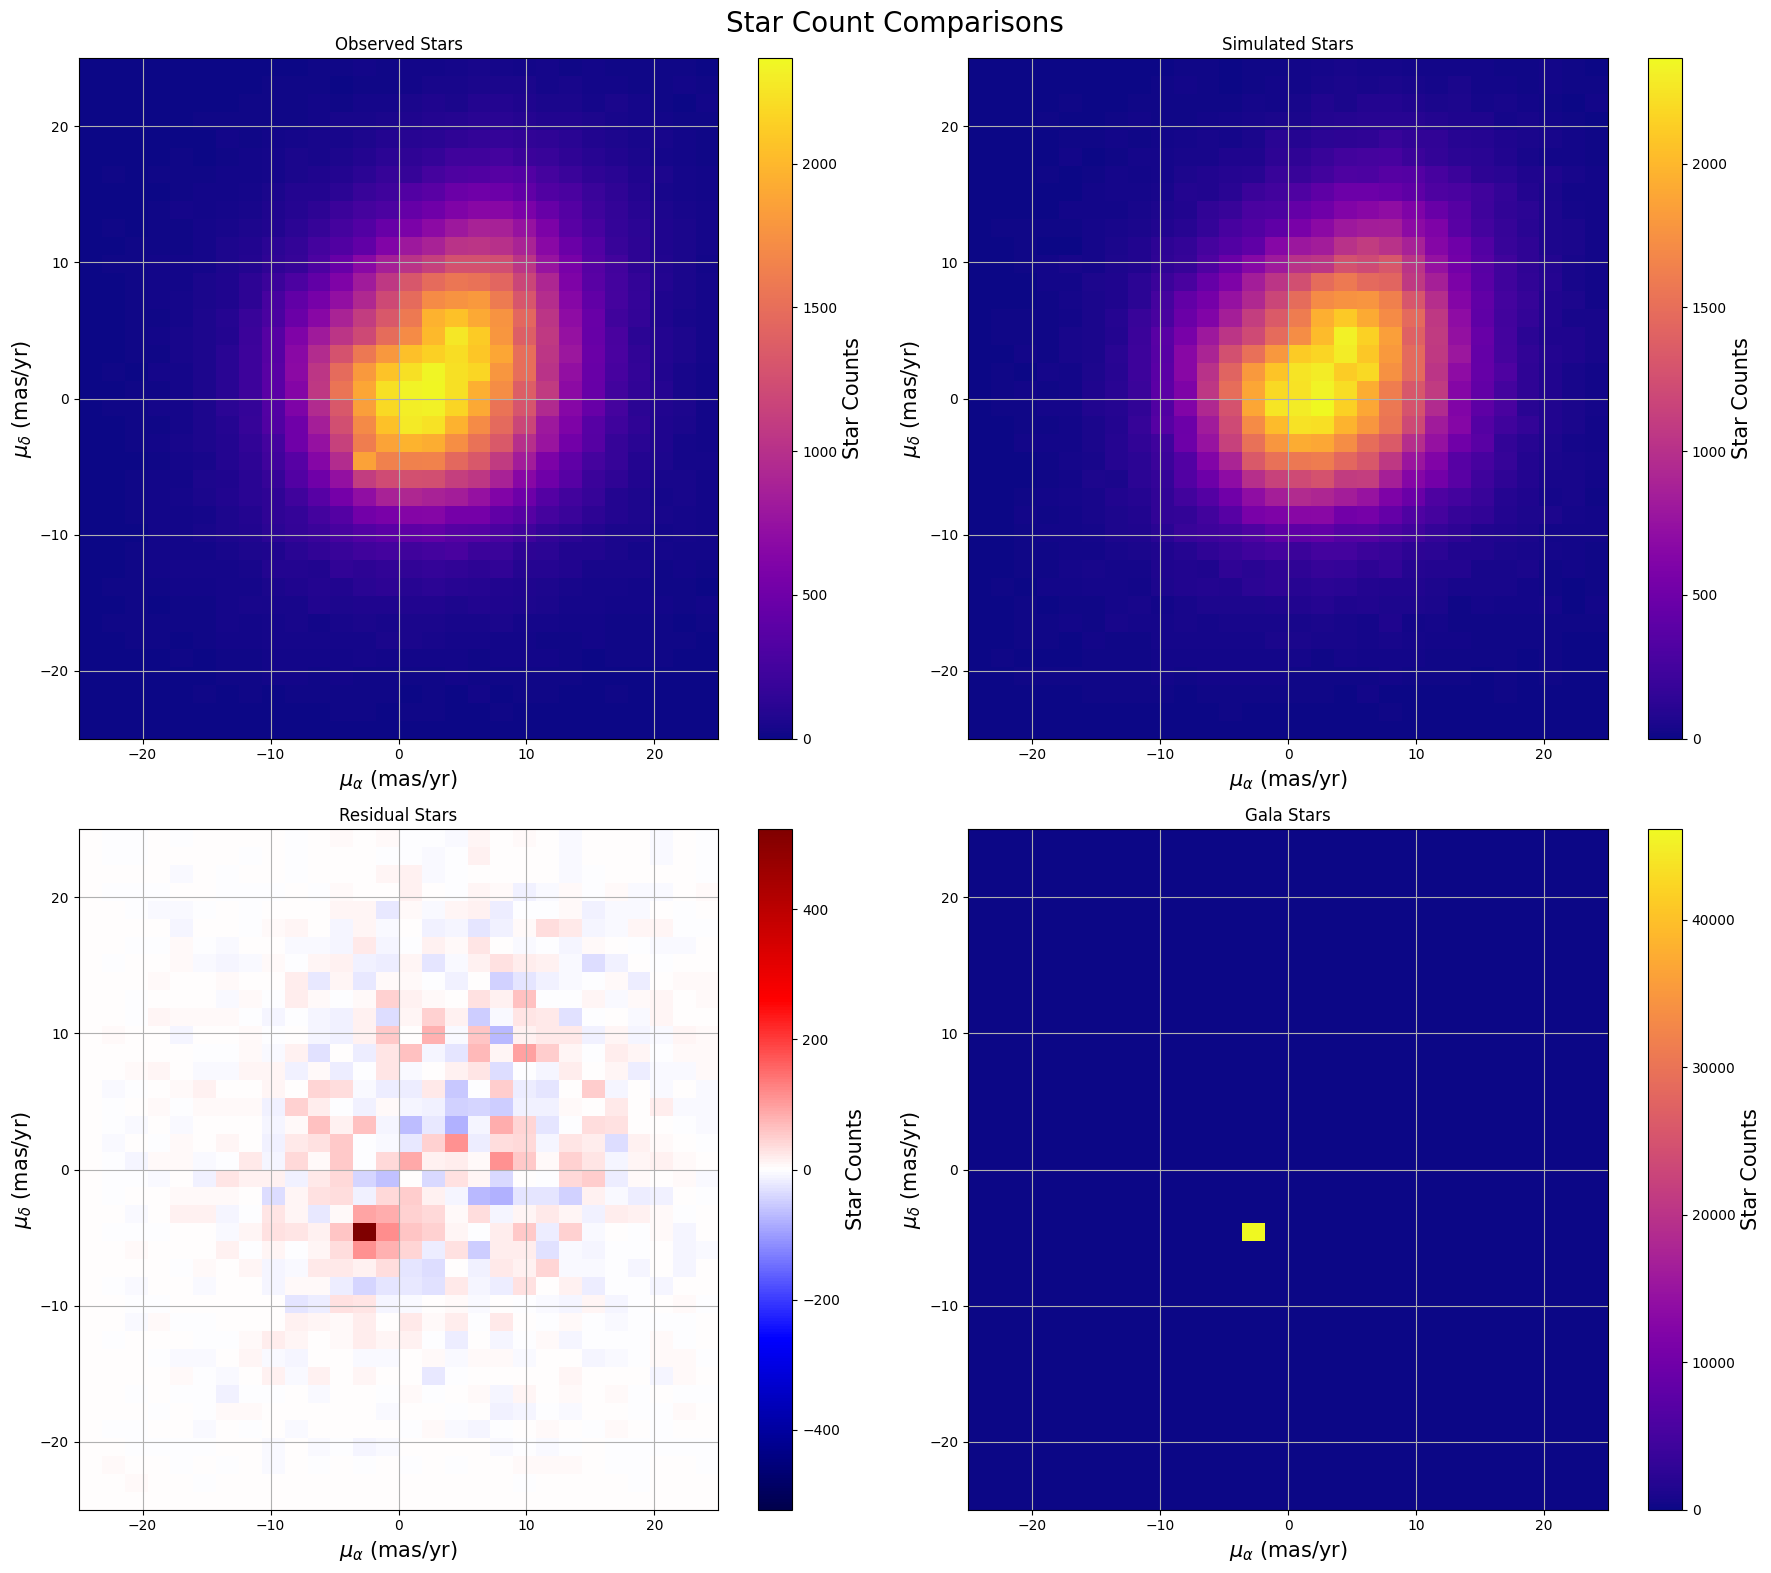

In [21]:
# Repeat for proper motions
fig, axs = plt.subplots(2, 2, figsize=(18, 16))
fig.suptitle('Star Count Comparisons', fontsize=20)
axs = axs.ravel()

# Determine the color bar range 
pm_vmin = min(simulated_voxel_counts_pmra_pmdec.min(), observed_voxel_counts_pmra_pmdec.min())
pm_vmax = max(simulated_voxel_counts_pmra_pmdec.max(), observed_voxel_counts_pmra_pmdec.max())
pmra_min, pmra_max = -25,25
pmdec_min, pmdec_max = -25,25

# Observed data
im1 = axs[0].imshow(observed_voxel_counts_pmra_pmdec[0:-3, 0:-3].T, origin='lower', cmap='plasma',
                    interpolation='none', aspect='auto', extent=[pmra_min, pmra_max, pmdec_min, pmdec_max], 
                    vmin=pm_vmin, vmax=pm_vmax)
axs[0].set_xlabel(r'$\mu_{\alpha}$ (mas/yr)', fontsize=15)
axs[0].set_ylabel(r'$\mu_{\delta}$ (mas/yr)', fontsize=15)
axs[0].set_title('Observed Stars')
axs[0].grid(True)
cbar1 = fig.colorbar(im1, ax=axs[0])
cbar1.set_label('Star Counts', fontsize=15)

# Simulated data
im2 = axs[1].imshow(simulated_voxel_counts_pmra_pmdec[0:-3, 0:-3].T, interpolation='none', cmap='plasma',
                    origin='lower', aspect='auto', extent=[pmra_min, pmra_max, pmdec_min, pmdec_max], 
                    vmin=pm_vmin, vmax=pm_vmax)
axs[1].set_xlabel(r'$\mu_{\alpha}$ (mas/yr)', fontsize=15)
axs[1].set_ylabel(r'$\mu_{\delta}$ (mas/yr)', fontsize=15)
axs[1].set_title('Simulated Stars')
axs[1].grid(True)
cbar2 = fig.colorbar(im2, ax=axs[1])
cbar2.set_label('Star Counts', fontsize=15)

# Residual stars
residual_pm_vmin = residual_counts_pmra_pmdec.min()
residual_pm_vmax = residual_counts_pmra_pmdec.max()

residual_abs_max = max(abs(residual_pm_vmin), abs(residual_pm_vmax))
residual_pm_vmin = -residual_abs_max # negative is for equal distribution about 0
residual_pm_vmax = residual_abs_max

im3 = axs[2].imshow(residual_counts_pmra_pmdec[0:-3, 0:-3].T, origin='lower', cmap='seismic', 
                    interpolation='none', aspect='auto', extent=[pmra_min, pmra_max, pmdec_min, pmdec_max], vmin=residual_pm_vmin, vmax = residual_pm_vmax)
axs[2].set_xlabel(r'$\mu_{\alpha}$ (mas/yr)', fontsize=15)
axs[2].set_ylabel(r'$\mu_{\delta}$ (mas/yr)', fontsize=15)
axs[2].set_title('Residual Stars')
axs[2].grid(True)
cbar3 = fig.colorbar(im3, ax=axs[2])
cbar3.set_label('Star Counts', fontsize=15)

# Gala stars
im4 = axs[3].imshow(gala_voxel_counts_pmra_pmdec[0:-3, 0:-3].T, origin='lower', cmap='plasma', 
                    interpolation='none', aspect='auto', extent=[pmra_min, pmra_max, pmdec_min, pmdec_max], vmin=0)
axs[3].set_xlabel(r'$\mu_{\alpha}$ (mas/yr)', fontsize=15)
axs[3].set_ylabel(r'$\mu_{\delta}$ (mas/yr)', fontsize=15)
axs[3].set_title('Gala Stars')
axs[3].grid(True)
cbar4 = fig.colorbar(im4, ax=axs[3])
cbar4.set_label('Star Counts', fontsize=15)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

We can now color-code by the Gala Weighted Residual Ratio and see how the observed stars look in position and proper motion space.

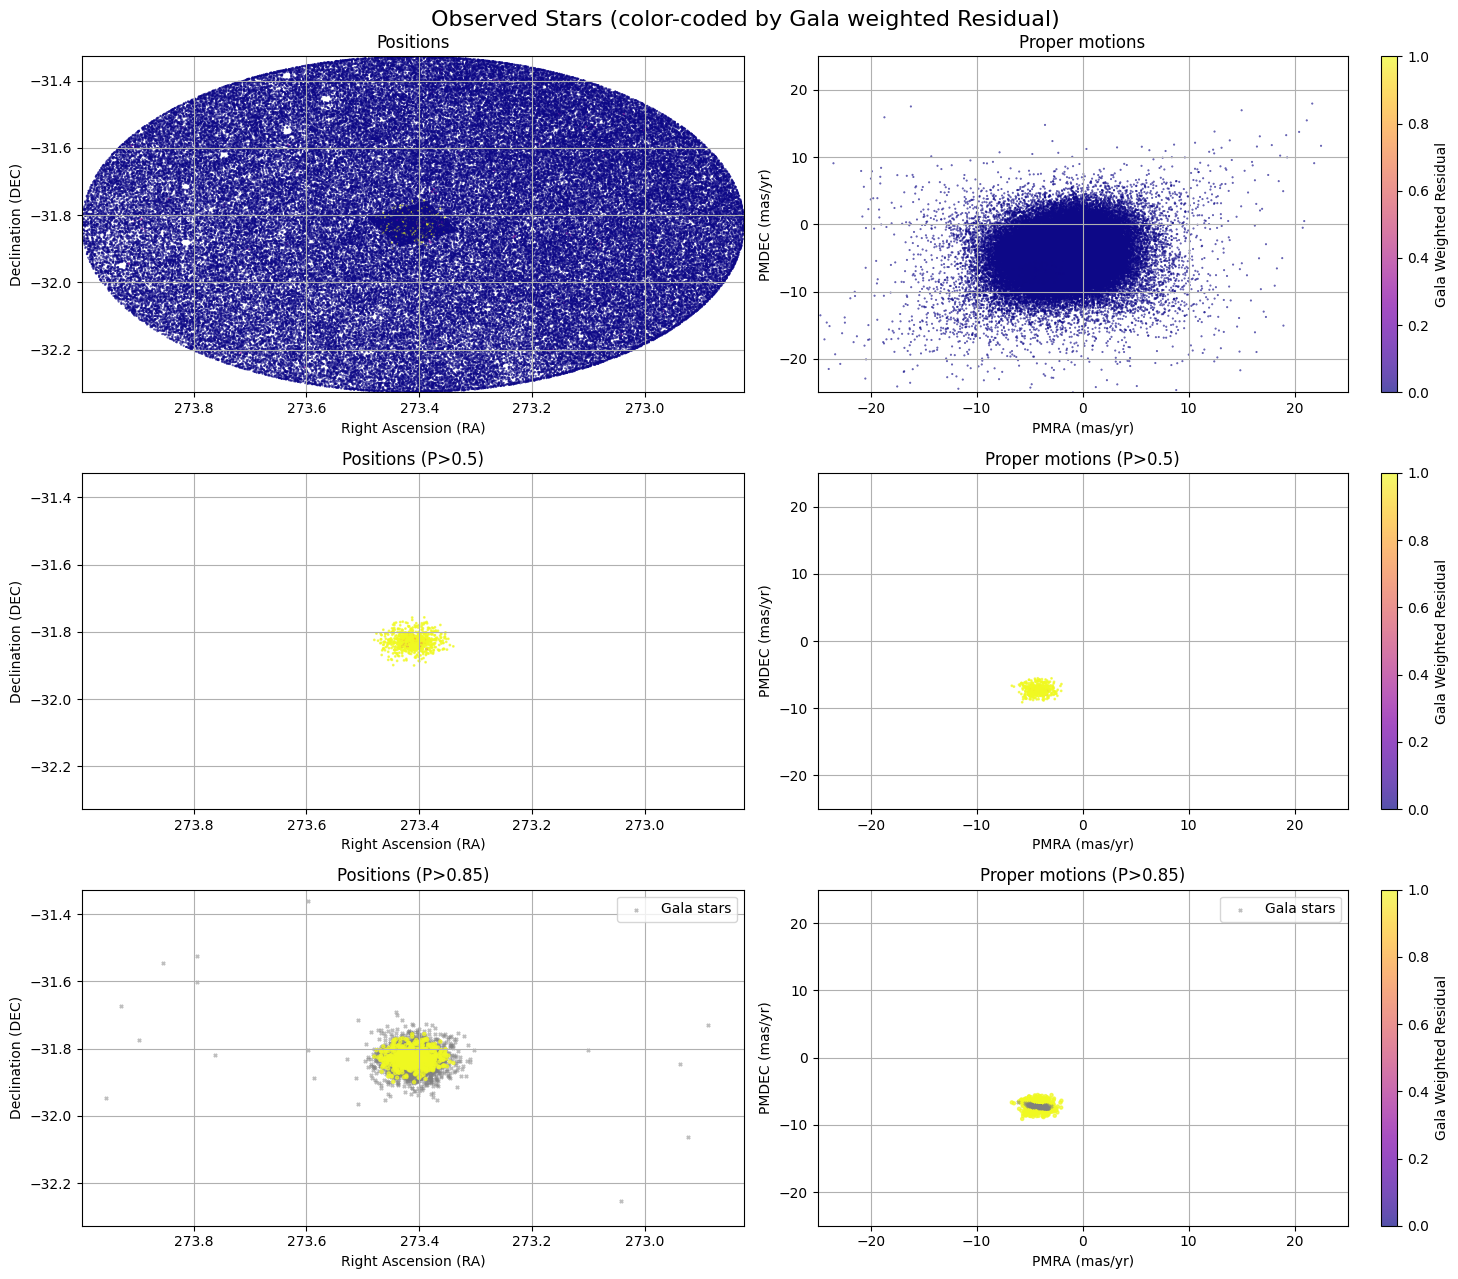

All stars: 311833
Med-to-high prob stars: 977
High prob stars: 936


In [28]:
fig, axs = plt.subplots(3, 2, figsize=(15, 13))
fig.suptitle("Observed Stars (color-coded by Gala weighted Residual)", fontsize=16)
axs = axs.ravel()

# Positions for all probability stars
scatter1 = axs[0].scatter(observed_probs_df['radeg'], observed_probs_df['decdeg'], 
                          c=observed_probs_df['Gala Weighted Residual'], cmap='plasma', 
                          s=0.25, alpha=0.7, vmin=0, vmax=1)
axs[0].set_xlim(ra_max, ra_min)
axs[0].set_ylim(dec_min, dec_max)
axs[0].set_xlabel('Right Ascension (RA)')
axs[0].set_ylabel('Declination (DEC)')
axs[0].set_title('Positions')
axs[0].grid()

# Motions for all probability stars
scatter2 = axs[1].scatter(observed_probs_df['pmra'], observed_probs_df['pmdec'], 
                          c=observed_probs_df['Gala Weighted Residual'], cmap='plasma', 
                          s=0.25, alpha=0.7, vmin=0, vmax=1)
axs[1].set_xlim(pmra_min,pmra_max)
axs[1].set_ylim(pmdec_min, pmdec_max)
axs[1].set_xlabel('PMRA (mas/yr)')
axs[1].set_ylabel('PMDEC (mas/yr)')
axs[1].set_title('Proper motions')
axs[1].grid()
# Set a colorbar for this row
cbar2 = fig.colorbar(scatter2, ax=axs[1])
cbar2.set_label('Gala Weighted Residual')


# Positions for P > 0.5 stars
scatter3 = axs[2].scatter(med_and_high_probs['radeg'], med_and_high_probs['decdeg'], 
                          c=med_and_high_probs['Gala Weighted Residual'], cmap='plasma', 
                          s=1, alpha=0.7, vmin=0, vmax=1)
axs[2].set_xlim(ra_max,ra_min)
axs[2].set_ylim(dec_min, dec_max)
axs[2].set_xlabel('Right Ascension (RA)')
axs[2].set_ylabel('Declination (DEC)')
axs[2].set_title('Positions (P>0.5)')
axs[2].grid()


# Motions for P > 0.5 stars
scatter4 = axs[3].scatter(med_and_high_probs['pmra'], med_and_high_probs['pmdec'], 
                          c=med_and_high_probs['Gala Weighted Residual'], cmap='plasma', 
                          s=1, alpha=0.7, vmin=0, vmax=1)
axs[3].set_xlim(pmra_min,pmra_max)
axs[3].set_ylim(pmdec_min, pmdec_max)
axs[3].set_xlabel('PMRA (mas/yr)')
axs[3].set_ylabel('PMDEC (mas/yr)')
axs[3].set_title('Proper motions (P>0.5)')
axs[3].grid()
# Add a colorbar for this row, but leave limits same as the first row so we still see the full scale of probs to compare
cbar4 = fig.colorbar(scatter2, ax=axs[3])
cbar4.set_label('Gala Weighted Residual')

# Positions for high probability stars. Overlay Gala predictions for comparison
scatter55 = axs[4].scatter(gala_df['RA'], gala_df['DEC'],  
                          s=5, alpha=0.5, color='grey', marker='x', label='Gala stars')
scatter5 = axs[4].scatter(high_probs['radeg'], high_probs['decdeg'], 
                          c=high_probs['Gala Weighted Residual'], cmap='plasma', 
                          s=5, alpha=0.7, vmin=0, vmax=1)
axs[4].set_xlim(ra_max, ra_min)
axs[4].set_ylim(dec_min, dec_max)
axs[4].set_xlabel('Right Ascension (RA)')
axs[4].set_ylabel('Declination (DEC)')
axs[4].set_title('Positions (P>0.85)')
axs[4].grid()
axs[4].legend(loc='upper right')


# Motions for high prob stars, with Gala comparisons
scatter6 = axs[5].scatter(high_probs['pmra'], high_probs['pmdec'], 
                          c=high_probs['Gala Weighted Residual'], cmap='plasma', 
                          s=5, alpha=0.7, vmin=0, vmax=1)
scatter66 = axs[5].scatter(gala_df['PM_RA'], gala_df['PM_DEC'],  
                          s=5, alpha=0.5, color='grey', marker='x', label='Gala stars') 
axs[5].set_xlim(pmra_min,pmra_max)
axs[5].set_ylim(pmdec_min, pmdec_max)
axs[5].set_xlabel('PMRA (mas/yr)')
axs[5].set_ylabel('PMDEC (mas/yr)')
axs[5].set_title('Proper motions (P>0.85)')
axs[5].grid()
axs[5].legend(loc='upper right')
# Add colorbar to last row
cbar6 = fig.colorbar(scatter2, ax=axs[5])
cbar6.set_label('Gala Weighted Residual')

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

# Also print the distribution of counts for each probability
print('All stars:', len(observed_df_cut['radeg']))
print('Med-to-high prob stars:', len(med_and_high_probs['radeg']))
print('High prob stars:', len(high_probs['radeg']))

We can also look at how these high probability stars look on a color-magnitude diagram, and compare that to an isochrone generated based off of the cluster's observed properties.

In [23]:
# Import isochrone to add to CMD
file_path ='C:/Users/smick/Desktop/Research/data/MIST_iso_FeHm0.7_aFep0.3_12p8Gyr_.txt'

# Extract the column headers from the file
column_names = None
with open(file_path, 'r') as f:
    for line in f:
        line = line.strip()
        # Identify the line that starts with "# EEP" and contains the column headers
        if line.startswith("# EEP"):
            # Strip leading '#' and extra spaces, then split by whitespace
            column_names = line.lstrip('# ').split()
            break

# Check if we found the column names
if column_names is None:
    raise ValueError("No header line found starting with '# EEP'")

# Read the data lines into a DataFrame
mist_iso = pd.read_csv(file_path, 
                 comment='#', 
                 delim_whitespace=True, 
                 names=column_names)


# Convert stars from absolute to apparent magnitude
distmod = 5*math.log10((10.1*1e3)/10)

iso_mu = mist_iso['SDSS_u'] + distmod
iso_mg = mist_iso['SDSS_g'] + distmod
iso_mr = mist_iso['SDSS_r'] + distmod
iso_mi = mist_iso['SDSS_i'] + distmod
iso_mz = mist_iso['SDSS_z'] + distmod

iso_u_g = mist_iso['SDSS_u'] - mist_iso['SDSS_g']
iso_g_r = mist_iso['SDSS_g'] - mist_iso['SDSS_r']
iso_g_z = mist_iso['SDSS_g'] - mist_iso['SDSS_z']
iso_r_i = mist_iso['SDSS_r'] - mist_iso['SDSS_i']
iso_i_z = mist_iso['SDSS_i'] - mist_iso['SDSS_z']
iso_g_z = mist_iso['SDSS_g'] - mist_iso['SDSS_z']


C:\Users\smick\AppData\Local\Temp\ipykernel_63224\3657411980.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mist_iso = pd.read_csv(file_path,


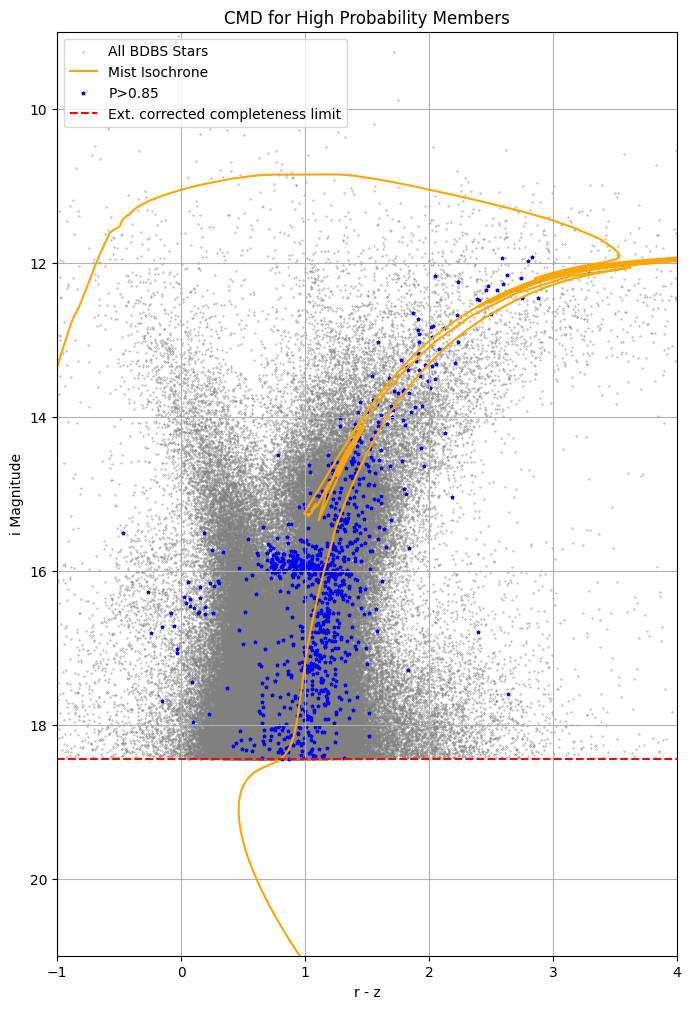

In [25]:
# Plot a CMD for the high probability members with field stars in background
plt.figure(figsize=(8, 12))

# Start with the full observed dataset, before truncation to completeness
plt.scatter((observed_df_cut['gmag_extcorr'] - observed_df_cut['zmag_extcorr']), 
           observed_df_cut['imag_extcorr'],
           s=0.1,
           alpha=1,
           color='grey',
           label='All BDBS Stars'
)

# MIST isochrone
plt.plot(iso_g_z, 
           iso_mi, # possibly accounting for extinction? 
           linestyle='-',
           alpha=1,
           color='orange',
           label='Mist Isochrone'
)

# High probability stars
plt.scatter((high_probs['gmag_extcorr'] - high_probs['zmag_extcorr']), 
           high_probs['imag_extcorr'],
           s=5,
           alpha=1,
           color='blue',
           marker='*',
           label='P>0.85'
)

# Set limits and labels
plt.ylim(21,9)
plt.xlim(-1,4)
plt.xlabel('r - z')
plt.ylabel('i Magnitude')

# Add in a horizontal line to indicate the completeness limit of the observed data
plt.axhline(y=19.1-avg_ext_i, color='red', linestyle='--', label='Ext. corrected completeness limit')
plt.title('CMD for High Probability Members')
plt.legend(loc='upper left')
plt.grid()
plt.show()

Repeat these steps for the gatekeeper residual for comparison

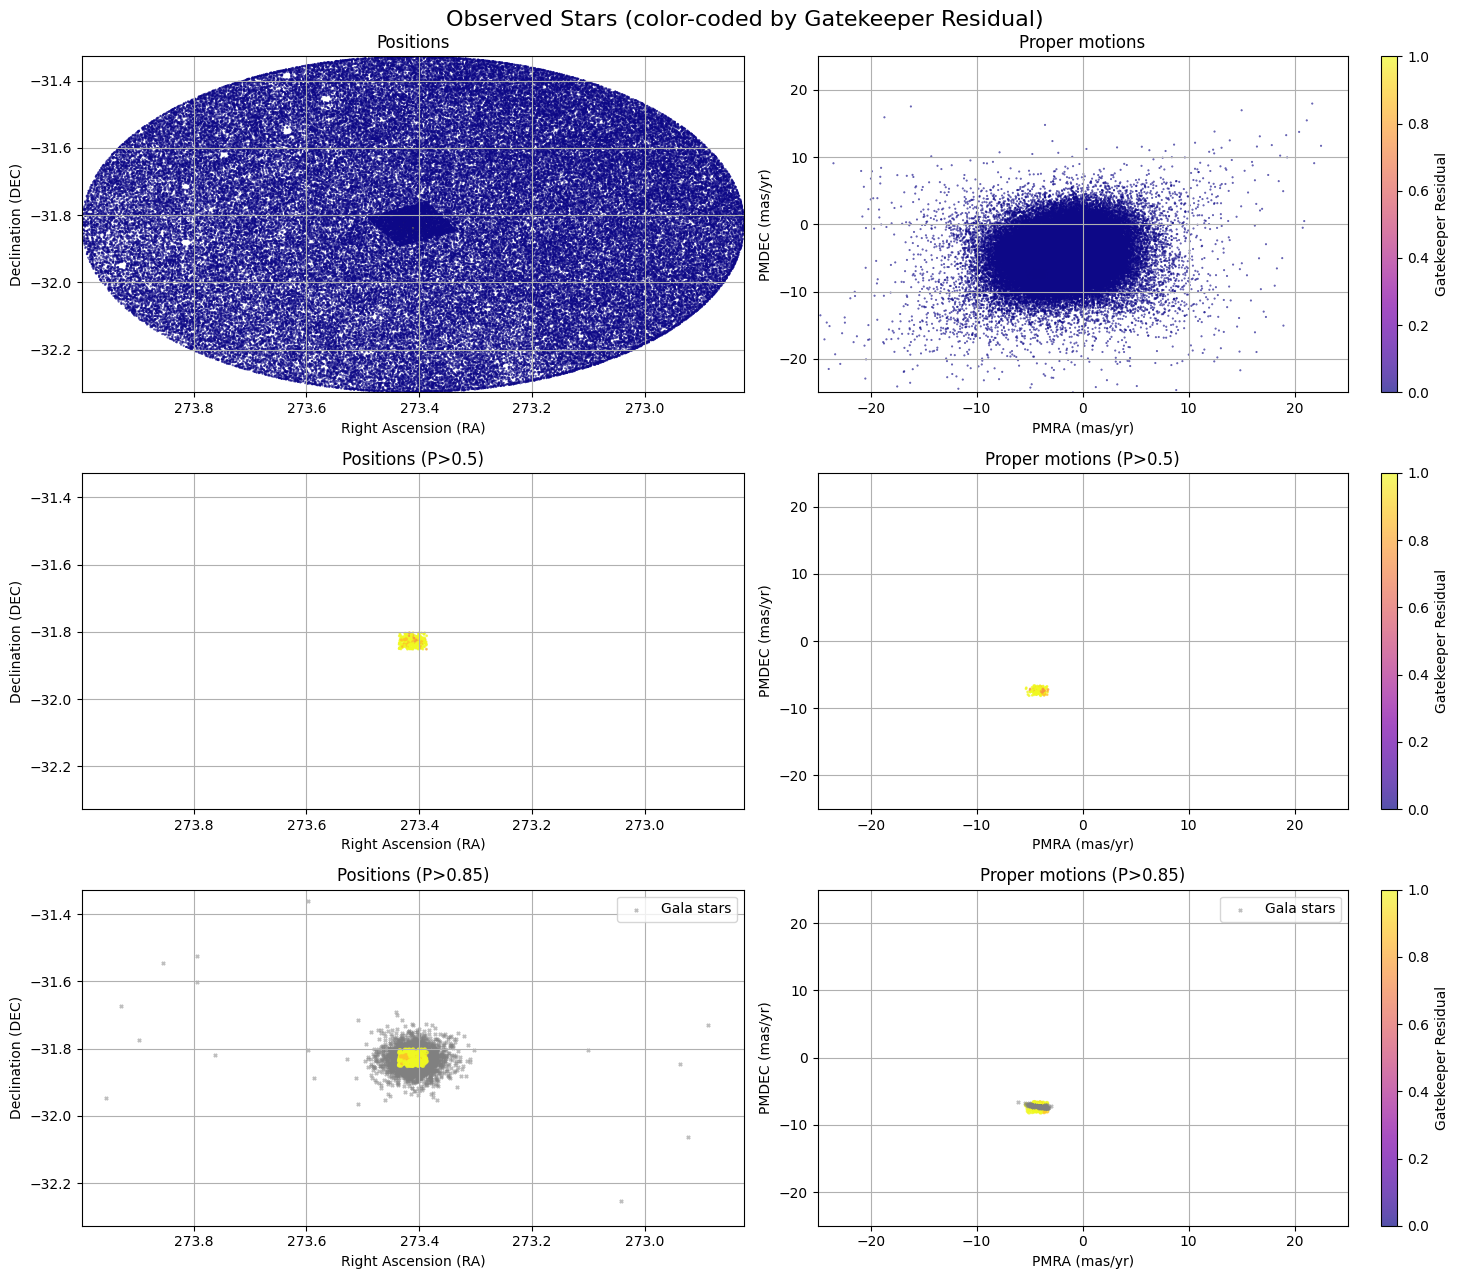

All stars: 311833
Med-to-high prob stars: 450
High prob stars: 437


In [29]:
fig, axs = plt.subplots(3, 2, figsize=(15, 13))
fig.suptitle("Observed Stars (color-coded by Gatekeeper Residual)", fontsize=16)
axs = axs.ravel()

# Positions for all probability stars
scatter1 = axs[0].scatter(observed_probs_df['radeg'], observed_probs_df['decdeg'], 
                          c=observed_probs_df['Gatekeeper Residual'], cmap='plasma', 
                          s=0.25, alpha=0.7, vmin=0, vmax=1)
axs[0].set_xlim(ra_max, ra_min)
axs[0].set_ylim(dec_min, dec_max)
axs[0].set_xlabel('Right Ascension (RA)')
axs[0].set_ylabel('Declination (DEC)')
axs[0].set_title('Positions')
axs[0].grid()

# Motions for all probability stars
scatter2 = axs[1].scatter(observed_probs_df['pmra'], observed_probs_df['pmdec'], 
                          c=observed_probs_df['Gatekeeper Residual'], cmap='plasma', 
                          s=0.25, alpha=0.7, vmin=0, vmax=1)
axs[1].set_xlim(pmra_min,pmra_max)
axs[1].set_ylim(pmdec_min, pmdec_max)
axs[1].set_xlabel('PMRA (mas/yr)')
axs[1].set_ylabel('PMDEC (mas/yr)')
axs[1].set_title('Proper motions')
axs[1].grid()
# Set a colorbar for this row
cbar2 = fig.colorbar(scatter2, ax=axs[1])
cbar2.set_label('Gatekeeper Residual')


# Positions for P > 0.5 stars
scatter3 = axs[2].scatter(gk_med_and_high_probs['radeg'], gk_med_and_high_probs['decdeg'], 
                          c=gk_med_and_high_probs['Gatekeeper Residual'], cmap='plasma', 
                          s=1, alpha=0.7, vmin=0, vmax=1)
axs[2].set_xlim(ra_max,ra_min)
axs[2].set_ylim(dec_min, dec_max)
axs[2].set_xlabel('Right Ascension (RA)')
axs[2].set_ylabel('Declination (DEC)')
axs[2].set_title('Positions (P>0.5)')
axs[2].grid()


# Motions for P > 0.5 stars
scatter4 = axs[3].scatter(gk_med_and_high_probs['pmra'], gk_med_and_high_probs['pmdec'], 
                          c=gk_med_and_high_probs['Gatekeeper Residual'], cmap='plasma', 
                          s=1, alpha=0.7, vmin=0, vmax=1)
axs[3].set_xlim(pmra_min,pmra_max)
axs[3].set_ylim(pmdec_min, pmdec_max)
axs[3].set_xlabel('PMRA (mas/yr)')
axs[3].set_ylabel('PMDEC (mas/yr)')
axs[3].set_title('Proper motions (P>0.5)')
axs[3].grid()
# Add a colorbar for this row, but leave limits same as the first row so we still see the full scale of probs to compare
cbar4 = fig.colorbar(scatter2, ax=axs[3])
cbar4.set_label('Gatekeeper Residual')

# Positions for high probability stars. Overlay Gala predictions for comparison
scatter55 = axs[4].scatter(gala_df['RA'], gala_df['DEC'],  
                          s=5, alpha=0.5, color='grey', marker='x', label='Gala stars')
scatter5 = axs[4].scatter(gk_high_probs['radeg'], gk_high_probs['decdeg'], 
                          c=gk_high_probs['Gatekeeper Residual'], cmap='plasma', 
                          s=5, alpha=0.7, vmin=0, vmax=1)
axs[4].set_xlim(ra_max, ra_min)
axs[4].set_ylim(dec_min, dec_max)
axs[4].set_xlabel('Right Ascension (RA)')
axs[4].set_ylabel('Declination (DEC)')
axs[4].set_title('Positions (P>0.85)')
axs[4].grid()
axs[4].legend(loc='upper right')


# Motions for high prob stars, with Gala comparisons
scatter6 = axs[5].scatter(gk_high_probs['pmra'], gk_high_probs['pmdec'], 
                          c=gk_high_probs['Gatekeeper Residual'], cmap='plasma', 
                          s=5, alpha=0.7, vmin=0, vmax=1)
scatter66 = axs[5].scatter(gala_df['PM_RA'], gala_df['PM_DEC'],  
                          s=5, alpha=0.5, color='grey', marker='x', label='Gala stars') 
axs[5].set_xlim(pmra_min,pmra_max)
axs[5].set_ylim(pmdec_min, pmdec_max)
axs[5].set_xlabel('PMRA (mas/yr)')
axs[5].set_ylabel('PMDEC (mas/yr)')
axs[5].set_title('Proper motions (P>0.85)')
axs[5].grid()
axs[5].legend(loc='upper right')
# Add colorbar to last row
cbar6 = fig.colorbar(scatter2, ax=axs[5])
cbar6.set_label('Gatekeeper Residual')

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

# Also print the distribution of counts for each probability
print('All stars:', len(observed_df_cut['radeg']))
print('Med-to-high prob stars:', len(gk_med_and_high_probs['radeg']))
print('High prob stars:', len(gk_high_probs['radeg']))

Lastly, if all looks good, export a .csv that contains our observed stars with the new membership information

In [27]:
observed_probs_df.to_csv('observed_stars_probabilities.csv', index=False)